In [2]:
%matplotlib inline
import os
import glob
import xarray as xr
import pdb
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
#import sys
#sys.path.insert(1, '../Tools/')
from IPython.core.display import Video
from dea_tools.datahandling import paths_to_datetimeindex
from dea_tools.plotting import rgb, xr_animation

In [3]:
def paths_to_datetimeindex(paths, string_slice=(0, 10)):
    """
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string.
    Parameters
    ----------
    paths : list of strings
        A list of file path strings that will be used to extract times
    string_slice : tuple
        An optional tuple giving the start and stop position that
        contains the time information in the provided paths. These are
        applied to the basename (i.e. file name) in each path, not the
        path itself. Defaults to (0, 10).
    Returns
    -------
    A pandas.DatetimeIndex object containing a 'datetime64[ns]' derived
    from the file paths provided by `paths`.
    """
    date_strings = [os.path.basename(i)[slice(*string_slice)]
                    for i in paths]
    return pd.to_datetime(date_strings, format='%Y%m')

In [2]:
! wget -r --no-parent -A 'S_202*concentration_v3.0.tif' ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/ -P /g/data/jk72/sc0554

--2022-04-27 14:43:34--  ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/
           => ‘/g/data/jk72/sc0554/sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/.listing’
Resolving sidads.colorado.edu (sidads.colorado.edu)... 128.138.135.20
Connecting to sidads.colorado.edu (sidads.colorado.edu)|128.138.135.20|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /DATASETS/NOAA/G02135/south/monthly/geotiff ... done.
==> PASV ... done.    ==> LIST ... done.

sidads.colorado.edu     [ <=>                ]     971  --.-KB/s    in 0s      

2022-04-27 14:43:36 (70.0 MB/s) - ‘/g/data/jk72/sc0554/sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/.listing’ saved [971]

Removed ‘/g/data/jk72/sc0554/sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/.listing’.
--2022-04-27 14:43:36--  ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/01_Jan/
  

27


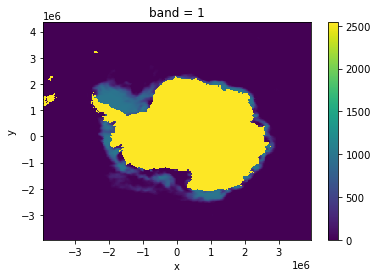

In [10]:
geotiff_list = []

for path in Path('/g/data/jk72/sc0554/sidads.colorado.edu/').rglob('*.tif'):
    geotiff_list.append(path)

geotiff_list = sorted(geotiff_list, key=lambda i: int(os.path.splitext(os.path.basename(i)[2:8])[0]))
print(len(geotiff_list))
xr.open_rasterio(geotiff_list[0]).plot()

In [7]:
# Create variable used for time axis
time_var = xr.Variable('time', paths_to_datetimeindex(geotiff_list,
                                                      string_slice=(2, 8)))

# Load in and concatenate all individual GeoTIFFs
geotiffs_da = xr.concat([xr.open_rasterio(i) for i in geotiff_list],
                        dim=time_var)

# Covert our xarray.DataArray into a xarray.Dataset
geotiffs_ds = geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
geotiffs_ds = geotiffs_ds.rename({1: 'conc'})

# Print the output
print(geotiffs_ds)

<xarray.Dataset>
Dimensions:  (time: 27, x: 316, y: 332)
Coordinates:
  * y        (y) float64 4.338e+06 4.312e+06 4.288e+06 ... -3.912e+06 -3.938e+06
  * x        (x) float64 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * time     (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2022-03-01
Data variables:
    conc     (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    transform:      (25000.0, 0.0, -3950000.0, 0.0, -25000.0, 4350000.0)
    crs:            +init=epsg:3412
    res:            (25000.0, 25000.0)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


In [6]:
time_var

<xarray.Variable (time: 27)>
array(['2020-01-01T00:00:00.000000000', '2020-02-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-04-01T00:00:00.000000000',
       '2020-05-01T00:00:00.000000000', '2020-06-01T00:00:00.000000000',
       '2020-07-01T00:00:00.000000000', '2020-08-01T00:00:00.000000000',
       '2020-09-01T00:00:00.000000000', '2020-10-01T00:00:00.000000000',
       '2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000', '2021-02-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000', '2021-04-01T00:00:00.000000000',
       '2021-05-01T00:00:00.000000000', '2021-06-01T00:00:00.000000000',
       '2021-07-01T00:00:00.000000000', '2021-08-01T00:00:00.000000000',
       '2021-09-01T00:00:00.000000000', '2021-10-01T00:00:00.000000000',
       '2021-11-01T00:00:00.000000000', '2021-12-01T00:00:00.000000000',
       '2022-01-01T00:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
# Produce time series animation of red, green and blue bands
xr_animation(ds=geotiffs_ds, 
             bands=['conc'],
             output_path='animated_timeseries.mp4',                                
             interval=200, 
             width_pixels=300,
             show_date='%b %Y')

# Plot animation
plt.close()
Video('animated_timeseries.mp4', embed=True)

Exporting animation to animated_timeseries.mp4
